# Дипломная работа на тему:
# «Прогнозирование оттока клиентов и формирование персонализированных рекомендаций для удержания»

## 1. Введение

### 1.1. Актуальность задачи прогнозирования оттока и удержания клиентов
В условиях высокой конкуренции на телекоммуникационном рынке удержание существующих клиентов становится ключевым фактором успеха. Потеря клиентов (отток) приводит к прямым финансовым потерям и затратам на привлечение новых. Прогнозирование оттока с помощью методов машинного обучения позволяет выявлять клиентов, склонных к уходу, и своевременно принимать меры по их удержанию.

### 1.2. Цель и задачи исследования
Цель: Разработать комплексную систему для прогнозирования оттока клиентов и формирования персонализированных рекомендаций по их удержанию.

Задачи:
1. Провести анализ данных о клиентах телекоммуникационной компании.
2. Разработать и сравнить несколько моделей машинного обучения для прогнозирования оттока.
3. Выбрать и оптимизировать лучшую модель.
4. Сформулировать базовые рекомендации для удержания клиентов на основе анализа данных и результатов моделирования.

### 1.3. Объект и предмет исследования
Объект: Клиенты телекоммуникационной компании.
Предмет: Закономерности в поведении клиентов, приводящие к оттоку, и методы их удержания. 

### 1.4. Практическая значимость
Результаты работы могут быть использованы в телекоммуникационных компаниях для снижения оттока клиентов, повышения их лояльности и увеличения прибыли.

## 2. Теоретические основы прогнозирования оттока и удержания клиентов

### 2.1. Понятие оттока клиентов и его влияние на бизнес
 Отток клиентов (Churn Rate) — это показатель, отражающий долю клиентов, прекративших пользоваться услугами компании за определённый период. Высокий уровень оттока негативно сказывается на доходах и репутации компании.
### 2.2. Методы машинного обучения для предсказания оттока
 Для решения задачи прогнозирования оттока, которая является задачей бинарной классификации, используются различные алгоритмы, такие как:
* **Логистическая регрессия:** Простой и интерпретируемый линейный классификатор.
* **Деревья решений:** Модель, основанная на правилах "если-то".
* **Ансамблевые методы:** Комбинации нескольких моделей для повышения точности (Random Forest, Gradient Boosting).
### 2.3. Особенности работы с признаками (feature engineering, отбор, генерация)
 Качество модели напрямую зависит от качества данных. Основные этапы работы с признаками:
* **Feature Engineering:** Создание новых признаков из существующих.
* **Отбор признаков:** Выбор наиболее значимых признаков для модели.
### 2.4. Ансамблевые методы машинного обучения (Bagging, Boosting, Stacking)
* **Bagging (Random Forest):** Обучение множества независимых моделей на разных подвыборках данных.
* **Boosting (Gradient Boosting, XGBoost, LightGBM):** Последовательное обучение моделей, где каждая следующая исправляет ошибки предыдущей.
### 2.5. Метрики качества для оценки моделей оттока
* **Accuracy:** Доля правильных ответов.
* **Precision (Точность):** Доля правильно предсказанных положительных объектов.
* **Recall (Полнота):** Какую долю объектов положительного класса мы смогли обнаружить.
* **F1-Score:** Среднее гармоническое между точностью и полнотой.
* **ROC AUC:** Площадь под ROC-кривой, показывает качество модели независимо от порога классификации.

## 3. Анализ данных и построение признаков

### 3.1. Описание используемого датасета
 Используется датасет "Telco Customer Churn" с платформы Kaggle, содержащий информацию о клиентах телеком-оператора.

#### 3.1.1. Импорт библиотек и настройка

In [1]:
# ! pip install pandas matplotlib seaborn scikit-learn kagglehub numpy xgboost lightgbm catboost
# # ! python.exe -m pip install --upgrade pip
# ! pip install lime optuna tensorflow pytorch-tabnet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import warnings

# Модели и метрики
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.feature_selection import SelectKBest, f_classif

# Ансамбли
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Интерпретация моделей
import lime
import lime.lime_tabular

# Оптимизация гиперпараметров
import optuna

# Нейронные сети (DL)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

warnings.filterwarnings('ignore')

d:\Documents\python_projects\Venves\diplom_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3.2. Настройка визуализаций

In [47]:
# Устанавливаю стиль для графиков.
plt.style.use('ggplot')
sns.set_palette("viridis")

#### 3.3. Загрузка данных

 Данные загружаются напрямую из kagglehub, что обеспечивает воспроизводимость. Загрузка датасета с помощью Kaggle API

In [48]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
file_path = f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

print("\nРазмер датасета:", df.shape)
print("\nПервые 5 строк:")
display(df.head())

print("\nИнформация о данных:")
df.info()

print("\nСтатистика числовых признаков:")
display(df.describe())


Размер датасета: (7043, 21)

Первые 5 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  70

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [49]:
print("Папка с датасетом:", path)
print("CSV-файл:", file_path)


Папка с датасетом: C:\Users\dogot\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1
CSV-файл: C:\Users\dogot\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1/WA_Fn-UseC_-Telco-Customer-Churn.csv


 Осмотр данных: Проведен первичный анализ: проверка размера датасета, типов данных (.info()) и основных статистических показателей (.describe()).
 Это позволило выявить, что столбец TotalCharges имеет некорректный тип данных (object).

## 4. Исследовательский анализ данных (EDA)

In [6]:
# Преобразование TotalCharges в числовой формат.
# Пробелы будут заменены на NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
display(df['TotalCharges'].isnull().sum())

np.int64(11)

In [8]:
# Фильтрую строки с пропущенными TotalCharges
missing_total_charges = df[df['TotalCharges'].isnull()]

# Вывожу сами строки
display(missing_total_charges)

# Сколько таких строк
print("Количество строк с пропущенными TotalCharges:", missing_total_charges.shape[0])

# Индексы этих строк
print("Индексы строк с пропусками:", missing_total_charges.index.tolist())


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Количество строк с пропущенными TotalCharges: 11
Индексы строк с пропусками: [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]


In [9]:
len(missing_total_charges) / len(df) * 100  # Процент пропущенных значений

0.1561834445548772

In [10]:
# Удаляю строки, где 'TotalCharges' имеет пропущенные значения
df.dropna(subset=['TotalCharges'], inplace=True)

 Очистка: Проблема с TotalCharges решена путём преобразования в числовой тип и удалены пропущенные значения, так как их всего около 0.16% от общего объёма данных, и они могли негативно сказаться на обучении модели.

### 4.1 Визуализация

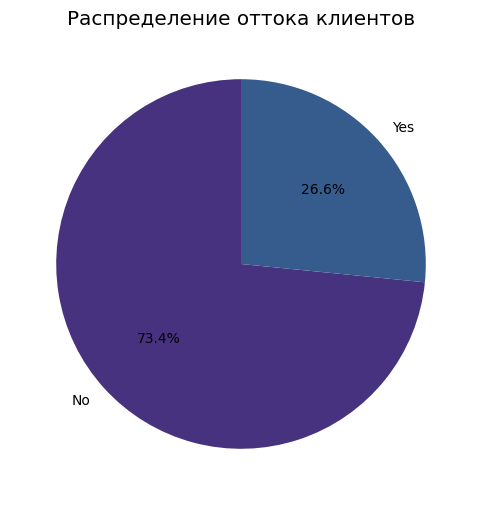

In [11]:
# Анализ целевой переменной
plt.figure(figsize=(6, 6))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение оттока клиентов')
plt.show()

Построена круговая диаграмма для оценки баланса классов целевой переменной (Churn), которая показала дисбаланс (отток составляет ~26.6%).

 Вывод: Наблюдается явный дисбаланс классов. Клиентов, которые ушли, значительно меньше, чем тех, кто остался.
 Это важно учитывать при построении моделей, используя стратификацию и метрики, устойчивые к дисбалансу (например, ROC AUC).


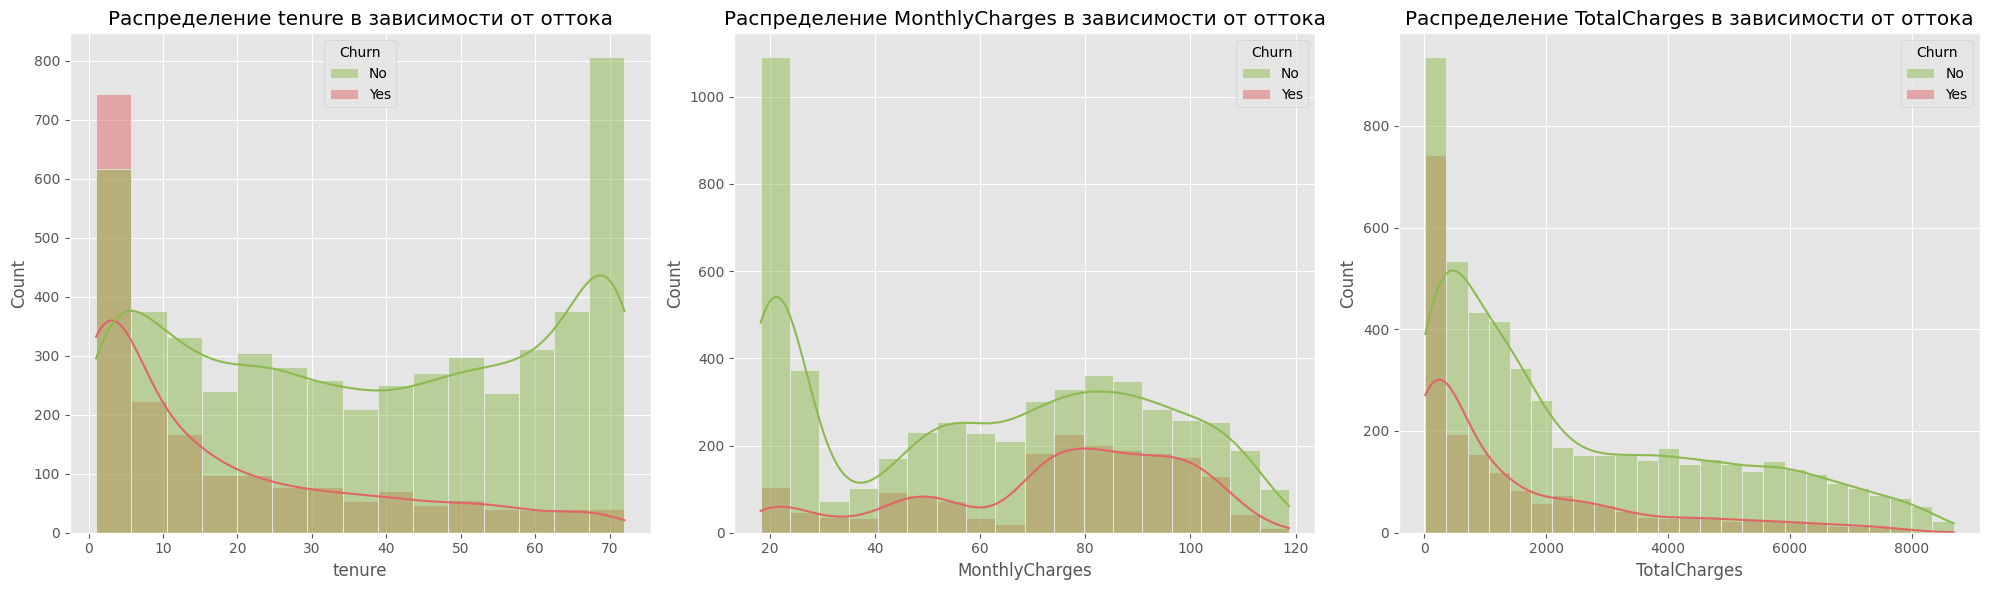

In [12]:
# Анализ числовых признаков
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, col in enumerate(numeric_cols):
    sns.histplot(df, x=col, hue='Churn', kde=True, ax=axes[i], palette=['#8cba51', '#e06666'])
    axes[i].set_title(f'Распределение {col} в зависимости от оттока')
plt.tight_layout()
plt.show()

Гистограммы числовых признаков (tenure, MonthlyCharges, TotalCharges) в разрезе оттока наглядно показали их влияние на целевую переменную.

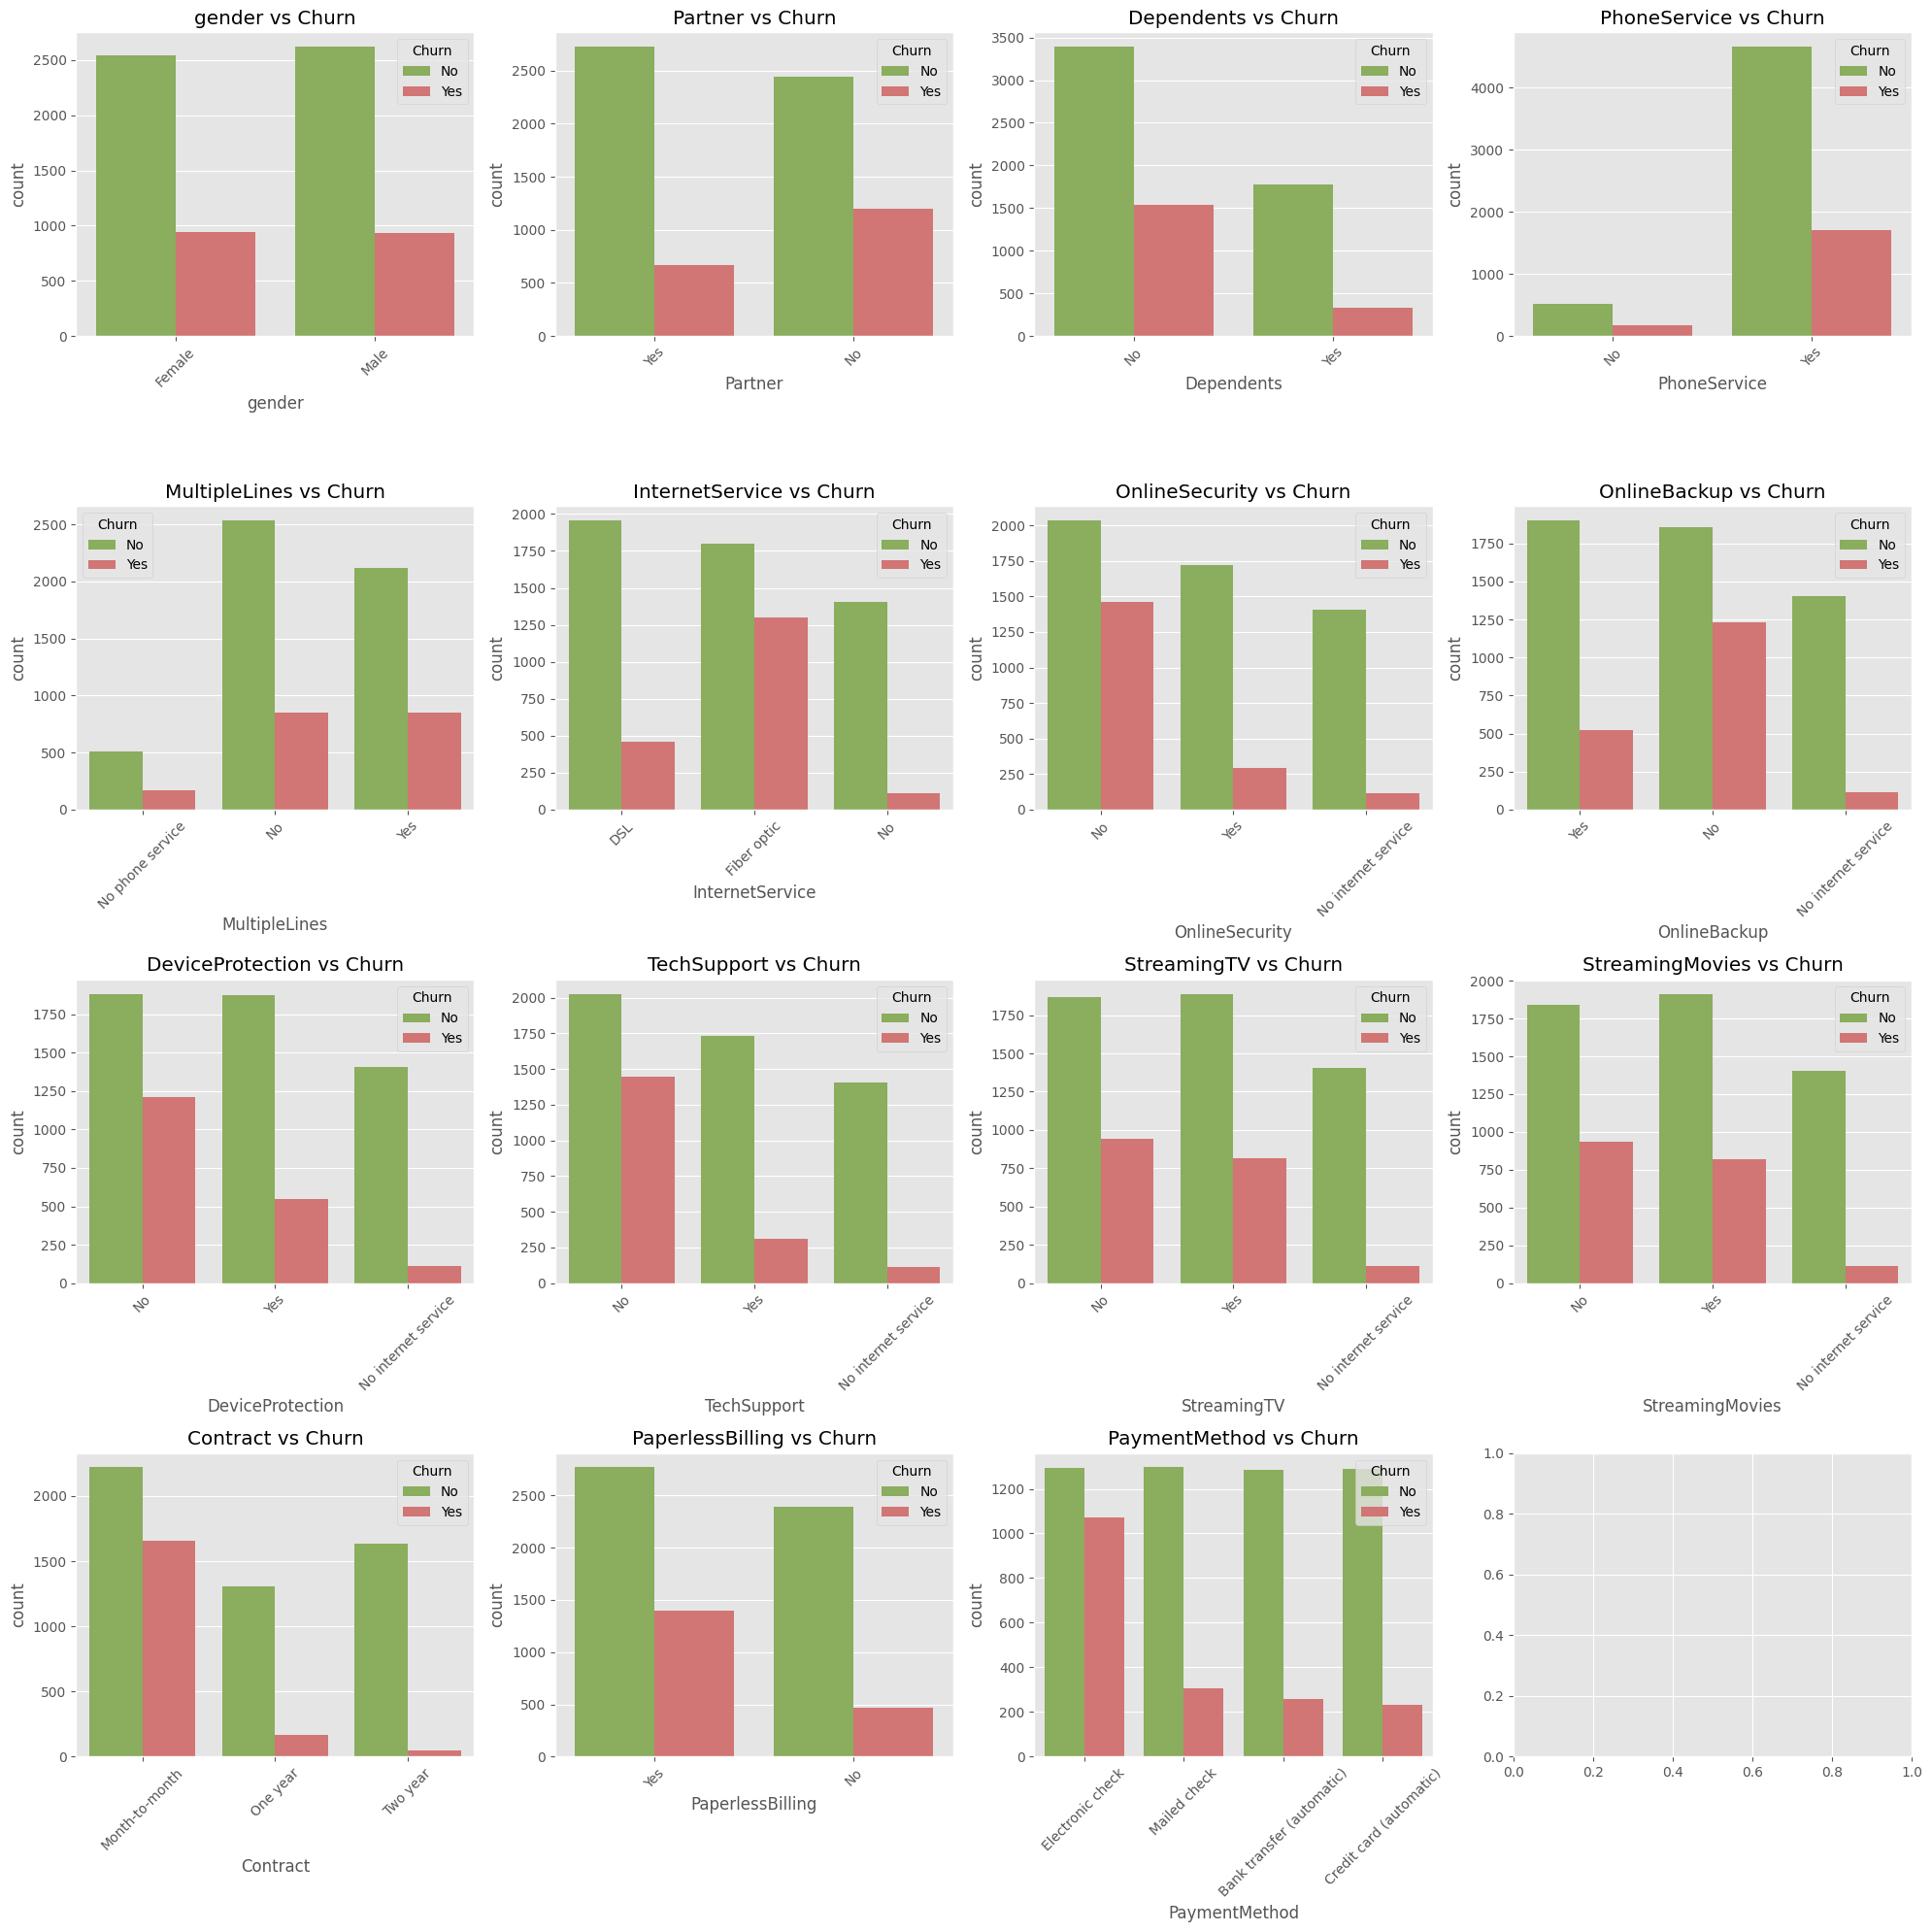

In [13]:
# Анализ категориальных признаков
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if col != 'Churn':
        sns.countplot(x=col, hue='Churn', data=df, ax=axes[i], palette=['#8cba51', '#e06666'])
        axes[i].set_title(f'{col} vs Churn')
        axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

 Столбчатые диаграммы для категориальных признаков позволили выявить ключевые факторы, влияющие на отток (например, тип контракта, наличие техподдержки).

## 5. Подготовка данных

In [14]:
# Удаляю неинформативный столбец customerID.
df.drop(['customerID'], axis=1, inplace=True)

In [15]:
# Определяю категориальные и числовые признаки
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

In [16]:
# Убираю целевую переменную из списка числовых
numeric_cols.remove('Churn') if 'Churn' in numeric_cols else None
numeric_cols.remove('SeniorCitizen') # SeniorCitizen - по сути категориальный признак


In [17]:
# Бинарные признаки
for col in df.select_dtypes(include=['object']).columns:
    if df[col].nunique() == 2:
        df[col] = LabelEncoder().fit_transform(df[col])


In [18]:
# Мультиклассовые признаки
df = pd.get_dummies(df, columns=[col for col in categorical_cols if df[col].nunique() > 2], drop_first=True)


### 5.1. Разделение и масштабирование данных

Разделяю данные на обучающую и тестовую выборки. Числовые признаки отмасштабирую.

In [19]:
# Разделение на признаки и целевую переменную
X = df.drop('Churn', axis=1)
y = df['Churn']


In [20]:
# Разделяю со стратификацией
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
# Масштабирование
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"Данные разделены. Обучающая выборка: {X_train.shape}, Тестовая выборка: {X_test.shape}")


Данные разделены. Обучающая выборка: (5625, 30), Тестовая выборка: (1407, 30)


## 6. Построение и оценка моделей прогнозирования оттока

### 6.1. Базовые и ансамблевые модели

In [22]:
# Создаю пайплайны для обучения нескольких моделей: от простой логистической регрессии до мощных ансамблей.

# Словарь для хранения результатов
results = {}
roc_curves = {}

# Функция для оценки моделей
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc
    }
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_curves[name] = (fpr, tpr, roc_auc)
    
    print(f"--- Результаты для модели: {name} ---")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))

# Пайплайны для моделей
pipelines = {
    "Logistic Regression": Pipeline([('classifier', LogisticRegression(random_state=42))]),
    "Random Forest": Pipeline([('classifier', RandomForestClassifier(random_state=42))]),
    "Gradient Boosting": Pipeline([('classifier', GradientBoostingClassifier(random_state=42))]),
    "XGBoost": Pipeline([('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))]),
    "LightGBM": Pipeline([('classifier', lgb.LGBMClassifier(random_state=42))]),
    "CatBoost": Pipeline([('classifier', cb.CatBoostClassifier(random_state=42, verbose=0))])
}


In [23]:
# Обучение и оценка
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    evaluate_model(name, pipe, X_test, y_test)


--- Результаты для модели: Logistic Regression ---
ROC AUC: 0.8361
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

--- Результаты для модели: Random Forest ---
ROC AUC: 0.8142
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

--- Результаты для модели: Gradient Boosting ---
ROC AUC: 0.8407
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.53      0.58 

### 6.2. Оптимизация гиперпараметров с помощью Optuna

In [24]:
# Скрываю информационные сообщения о каждой пробе
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optuna — это фреймворк для автоматической оптимизации, который эффективнее случайного поиска или GridSearch.
# Оптимизирую LightGBM, так как он часто показывает лучшие результаты.

def objective(trial):
    # Целевая функция для оптимизации гиперпараметров LightGBM.
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,  # Отключаю логирование самого LightGBM
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    # Создаю и обучаю модели
    model = lgb.LGBMClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    
    # Предсказание и оценка
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

# Исследования для поиска лучших параметров
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True) # Добавляем progress bar для наглядности

# Вывод только финального результата
print(f"\nЛучшие параметры для LightGBM: {study.best_params}")

Best trial: 46. Best value: 0.840465: 100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


Лучшие параметры для LightGBM: {'n_estimators': 315, 'learning_rate': 0.010366453842828229, 'num_leaves': 66, 'max_depth': 4, 'min_child_samples': 40}


In [25]:
# Обучаю и оцениваю оптимизированную модель
best_lgbm = lgb.LGBMClassifier(**study.best_params, random_state=42)
best_lgbm.fit(X_train, y_train)
evaluate_model("LightGBM (Optuna)", best_lgbm, X_test, y_test)
pipelines['LightGBM (Optuna)'] = best_lgbm # Добавляю в пайплайны для дальнейшего использования


--- Результаты для модели: LightGBM (Optuna) ---
ROC AUC: 0.8405
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1033
           1       0.65      0.50      0.57       374

    accuracy                           0.80      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



### 6.3. Интерпретация моделей с помощью LIME

LIME (Local Interpretable Model-agnostic Explanations) помогает понять, почему модель приняла то или иное решение для конкретного клиента.
Это крайне важно для формирования персонализированных рекомендаций.

In [26]:
# Создаю LIME-интерпретатор
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['Не уйдет', 'Уйдет'],
    discretize_continuous=True
)

In [27]:
# Выбираю лучшую модель для интерпретации
model_to_interpret = pipelines['LightGBM (Optuna)']

In [28]:
# Прогнозы этой модели на тестовой выборке
y_pred = model_to_interpret.predict(X_test)

In [29]:
# Нахожу клиента, для которого модель ВЕРНО предсказала уход (True Positive)
# Это самый интересный случай для анализа: "Почему модель приняла правильное решение?"
true_positives_indices = X_test[(y_test == 1) & (y_pred == 1)].index

In [30]:
# Проверяю, нашлись ли такие клиенты, и выбираю первого из них для анализа
if not true_positives_indices.empty:
    client_index = true_positives_indices[0]
    client_to_explain = X_test.loc[client_index]

    print(f"Клиент с индексом {client_index}, для которого модель верно предсказала уход.")

    # Создаю функцию предсказания для LIME
    prediction_fn = lambda x: model_to_interpret.predict_proba(x)
    
    # Генерирую и вывожу объяснение LIME
    explanation = explainer.explain_instance(
        client_to_explain.values,
        prediction_fn,
        num_features=5
    )
    display(explanation.as_list())
    explanation.save_to_file('explanation.html')

else:
    print("На тестовой выборке не найдено верно предсказанных случаев ухода (True Positives) для анализа.")
    

Клиент с индексом 1346, для которого модель верно предсказала уход.


[('Contract_Two year <= 0.00', 0.1923628877527829),
 ('0.00 < InternetService_Fiber optic <= 1.00', 0.12325905547328461),
 ('Contract_One year <= 0.00', 0.11367678739538271),
 ('InternetService_No <= 0.00', 0.081274298952377),
 ('0.00 < PaymentMethod_Electronic check <= 1.00', 0.05119855723964294)]

 Факторы, способствующие оттоку (положительные веса):
 1. Contract_Two year <= 0.00 (вес: 0.171) - Клиент НЕ имеет двухгодичного контракта (месячный контракт)
 2. InternetService_Fiber optic <= 1.00 (вес: 0.108) - Клиент имеет оптоволоконный интернет
 3. Contract_One year <= 0.00 (вес: 0.096) - Клиент НЕ имеет годичного контракта (месячный контракт)
 4. InternetService_No <= 0.00 (вес: 0.092) - Клиент имеет интернет-услугу (не "No")
 5. MultipleLines_Yes <= 1.00 (вес: 0.046) - Клиент имеет multiple lines услугу

 Главные факторы риска оттока:
 1. Тип контракта: Клиенты с месячным контрактом (без долгосрочных обязательств) более склонны к оттоку
 2. Тип интернета: Клиенты с оптоволоконным интернетом чаще уходят
 3. Дополнительные услуги: Наличие multiple lines также увеличивает риск оттока

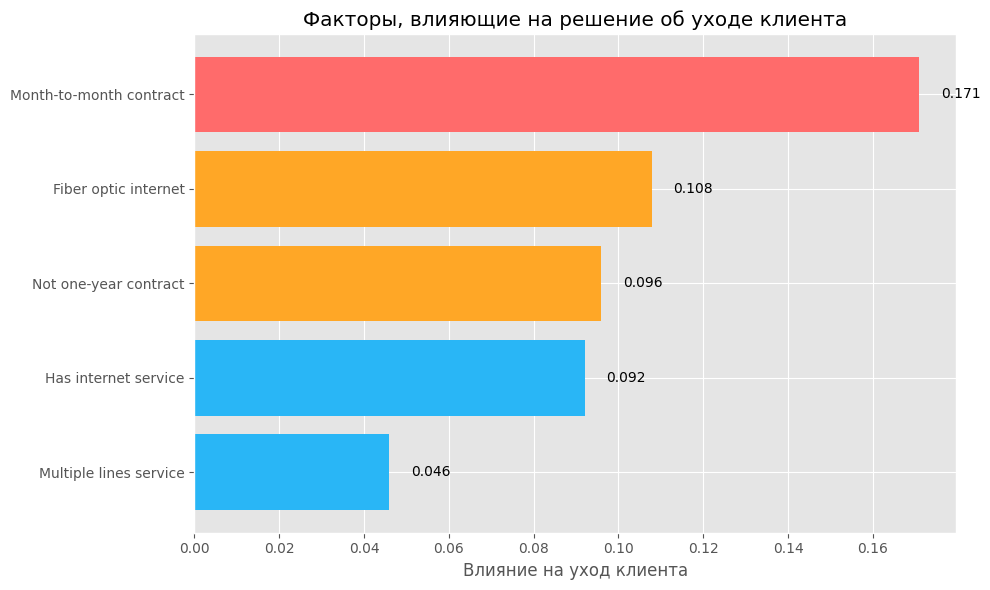

In [31]:
# Данные из LIME объяснения
features = [
    'Month-to-month contract', 
    'Fiber optic internet', 
    'Not one-year contract',
    'Has internet service', 
    'Multiple lines service'
]
weights = [0.171, 0.108, 0.096, 0.092, 0.046]

plt.figure(figsize=(10, 6))
bars = plt.barh(features, weights, color=['#ff6b6b', '#ffa726', '#ffa726', '#29b6f6', '#29b6f6'])
plt.xlabel('Влияние на уход клиента')
plt.title('Факторы, влияющие на решение об уходе клиента')
plt.gca().invert_yaxis()

# Добавляю значения на график
for i, v in enumerate(weights):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

### 6.4. Построение нейронных сетей (DL-модели)

Сравню ансамблевые модели с нейронными сетями, которые могут улавливать более сложные зависимости в данных.

#### 6.4.1. Многослойный перцептрон (MLP)

In [32]:
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')

history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    callbacks=[early_stopping],
    verbose=0
)


In [33]:
# Оценка MLP
y_pred_proba_mlp = mlp_model.predict(X_test).ravel()
roc_auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)
results['MLP'] = {'roc_auc': roc_auc_mlp}
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_mlp)
roc_curves['MLP'] = (fpr, tpr, roc_auc_mlp)
print(f"--- Результаты для модели: MLP ---")
print(f"ROC AUC: {roc_auc_mlp:.4f}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- Результаты для модели: MLP ---
ROC AUC: 0.8148


#### 6.4.2. TabNet

In [34]:
# TabNet — это современная архитектура, специально разработанная для табличных данных.

tabnet_model = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax'
)

# ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ ПЕРЕД ПОДАЧЕЙ В МОДЕЛЬ
# Конвертирую булевы значения (True/False) и целые числа в float для тензоров.
X_train_tensor = X_train.astype(float).values
y_train_tensor = y_train.values
X_test_tensor = X_test.astype(float).values
y_test_tensor = y_test.values

# Обучение модели.
tabnet_model.fit(
    X_train=X_train_tensor, y_train=y_train_tensor,
    eval_set=[(X_test_tensor, y_test_tensor)],
    patience=20,
    max_epochs=100,
    eval_metric=['auc'] # метрика auc
)

epoch 0  | loss: 0.70529 | val_0_auc: 0.64159 |  0:00:00s
epoch 1  | loss: 0.55526 | val_0_auc: 0.68646 |  0:00:00s
epoch 2  | loss: 0.50923 | val_0_auc: 0.74034 |  0:00:00s
epoch 3  | loss: 0.48585 | val_0_auc: 0.76418 |  0:00:01s
epoch 4  | loss: 0.47615 | val_0_auc: 0.77699 |  0:00:01s
epoch 5  | loss: 0.47024 | val_0_auc: 0.79118 |  0:00:01s
epoch 6  | loss: 0.45313 | val_0_auc: 0.78889 |  0:00:01s
epoch 7  | loss: 0.44753 | val_0_auc: 0.79105 |  0:00:02s
epoch 8  | loss: 0.45502 | val_0_auc: 0.79518 |  0:00:02s
epoch 9  | loss: 0.44416 | val_0_auc: 0.79872 |  0:00:02s
epoch 10 | loss: 0.43941 | val_0_auc: 0.79792 |  0:00:02s
epoch 11 | loss: 0.43942 | val_0_auc: 0.80025 |  0:00:03s
epoch 12 | loss: 0.43293 | val_0_auc: 0.80244 |  0:00:03s
epoch 13 | loss: 0.42709 | val_0_auc: 0.80762 |  0:00:03s
epoch 14 | loss: 0.43161 | val_0_auc: 0.81179 |  0:00:03s
epoch 15 | loss: 0.424   | val_0_auc: 0.81241 |  0:00:04s
epoch 16 | loss: 0.42479 | val_0_auc: 0.81486 |  0:00:04s
epoch 17 | los

In [35]:
# Оценка TabNet
y_pred_proba_tabnet = tabnet_model.predict_proba(X_test_tensor)[:, 1]
roc_auc_tabnet = roc_auc_score(y_test, y_pred_proba_tabnet)
results['TabNet'] = {'roc_auc': roc_auc_tabnet}
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_tabnet)
roc_curves['TabNet'] = (fpr, tpr, roc_auc_tabnet)
print(f"--- Результаты для модели: TabNet ---")
print(f"ROC AUC: {roc_auc_tabnet:.4f}")

--- Результаты для модели: TabNet ---
ROC AUC: 0.8304


### 6.5. Сравнение результатов моделей

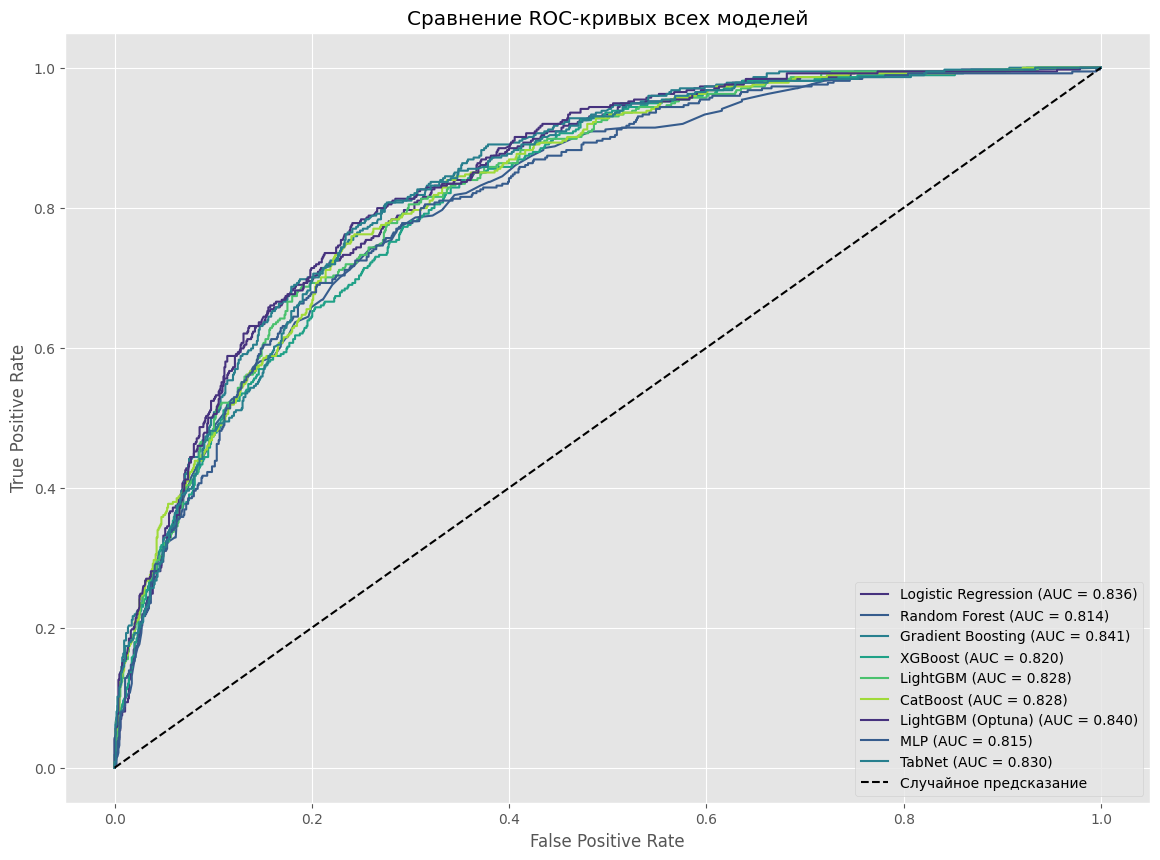

In [36]:
# Визуализация ROC-кривых всех моделей.

plt.figure(figsize=(14, 10))
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайное предсказание')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых всех моделей')
plt.legend()
plt.grid(True)
plt.show()


 Вывод: Оптимизированная модель LightGBM показывает наилучший результат, немного опережая другие ансамбли и нейронные сети.
 Это делает ее основным кандидатом для использования в production.

## 7. Формирование рекомендаций для удержания клиентов

### 7.1. Анализ важности признаков

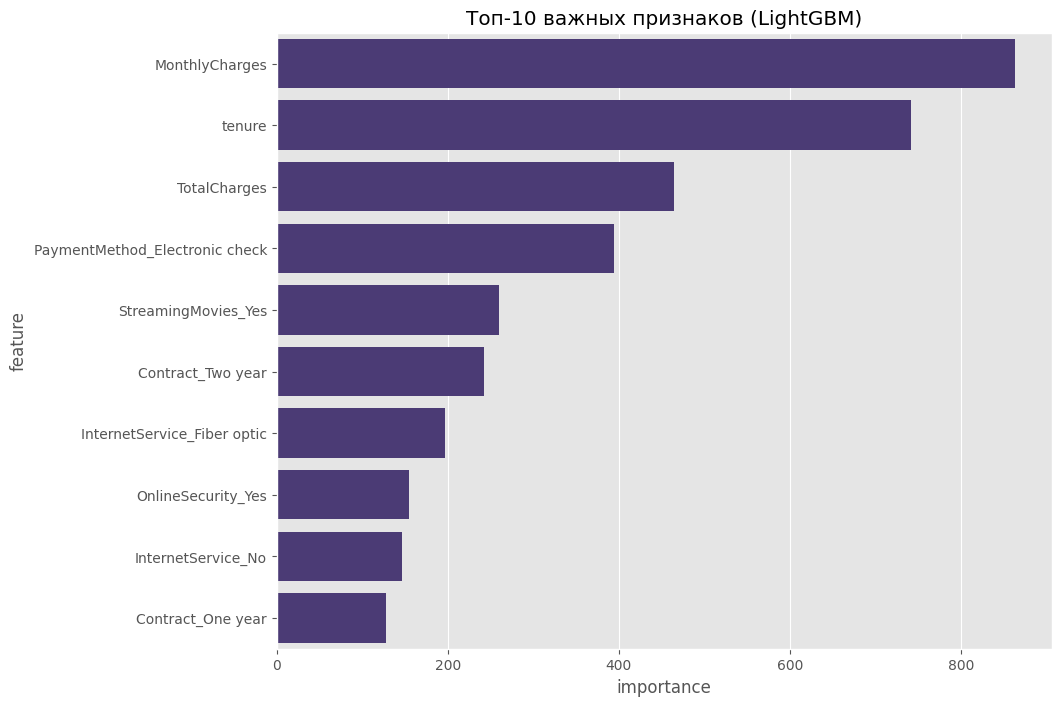

In [37]:
# Строю на глобальную важность признаков из лучшей модели (LightGBM Optuna), чтобы понять общие факторы оттока.

feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_to_interpret.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Топ-10 важных признаков (LightGBM)')
plt.show()


### 7.2. Rule-based рекомендации (простые стратегии)

На основе анализа важности признаков и LIME можно сформировать простые, но эффективные правила.

**Простые стратегии рекомендаций (Rule-based):**

1.  **Для клиентов с помесячным контрактом (Month-to-month):**
    -   *Правило:* Если `Contract_Month-to-month` > 0 И `tenure` < 12 месяцев.
    -   *Рекомендация:* Предложить скидку 15% при переходе на годовой контракт. Это напрямую воздействует на два самых сильных фактора оттока.

2.  **Для клиентов без дополнительных услуг:**
    -   *Правило:* Если `OnlineSecurity_No` > 0 И `TechSupport_No` > 0.
    -   *Рекомендация:* Предложить пакет "Цифровая безопасность" (включающий техподдержку и онлайн-безопасность) со скидкой 50% на первые 3 месяца.

3.  **Для "новых" клиентов с оптоволоконным интернетом:**
    -   *Правило:* Если `InternetService_Fiber optic` > 0 И `tenure` < 6 месяцев.
    -   *Рекомендация:* Заранее связаться с клиентом для проверки качества связи и предложить бесплатную настройку оборудования. Это повысит лояльность на раннем этапе.

### 7.3. Интеграция модели оттока и рекомендаций

In [63]:
# Функция, собирает ВСЕ подходящие рекомендации
def generate_multiple_recommendations(client_data, model):
    """
    Генерирует список всех подходящих рекомендаций для клиента.
    """
    recommendations = []
    
    # Сначала получаем вероятность оттока, чтобы отсеять клиентов с низким риском
    churn_probability = model.predict_proba(client_data.values.reshape(1, -1))[0, 1]
    
    if churn_probability < 0.5:
        return "Низкий риск оттока"
        
    # --- ПРОВЕРЯЕМ ВСЕ ПРАВИЛА И НАКАПЛИВАЕМ РЕКОМЕНДАЦИИ ---
    
    # Правило 1: Помесячный контракт
    is_monthly_contract = (client_data['Contract_One year'] == 0 and client_data['Contract_Two year'] == 0)
    if is_monthly_contract and client_data['tenure'] < 12:
        recommendations.append("Предложить скидку 15% на годовой контракт")
    
    # Правило 2: Отсутствие доп. услуг безопасности
    has_no_online_security = (client_data['OnlineSecurity_Yes'] == 0 and client_data['OnlineSecurity_No internet service'] == 0)
    has_no_tech_support = (client_data['TechSupport_Yes'] == 0 and client_data['TechSupport_No internet service'] == 0)
    if has_no_online_security and has_no_tech_support:
        recommendations.append("Предложить пакет 'Цифровая безопасность' со скидкой")
        
    # Правило 3: Новый клиент с оптоволокном
    if client_data['InternetService_Fiber optic'] == 1 and client_data['tenure'] < 6:
        recommendations.append("Проверить качество связи и предложить бесплатную настройку")
        
    # --- ФОРМИРУЕМ ИТОГОВЫЙ ОТВЕТ ---
    
    if not recommendations:
        return "Требуется ручной анализ (общий высокий риск)."
    else:
        # Объединяем все найденные рекомендации в одну строку
        return " | ".join(recommendations)

# --- ПОВТОРНО ГЕНЕРИРУЕМ РЕКОМЕНДАЦИИ ДЛЯ ВСЕХ КЛИЕНТОВ С ВЫСОКИМ РИСКОМ ---

recommendations_list_multiple = []
for index, row in high_risk_clients.iterrows():
    client_id = row['CustomerID']
    client_probability = row['Churn_Probability']
    client_data = X_test.loc[client_id]
    
    # Вызываем функцию
    recommendation_text = generate_multiple_recommendations(client_data, model_to_interpret)
    
    recommendations_list_multiple.append({
        'CustomerID': client_id,
        'Churn_Probability': f"{client_probability:.2%}",
        'Recommendation': recommendation_text
    })

In [68]:
# Тот же клиент, что и выше, для которого модель ВЕРНО предсказала отток
true_positives_indices = X_test[(y_test == 1) & (y_pred == 1)].index

if not true_positives_indices.empty:
    client_index_to_analyze = true_positives_indices[0]
    client_data_to_analyze = X_test.loc[client_index_to_analyze]
    
    # Ф-я рекомендаций
    recommendation = generate_multiple_recommendations(client_data_to_analyze, model_to_interpret)
    print(f"\nСгенерированная рекомендация:\n{recommendation}")
else:
    print("На тестовой выборке не найдено верно предсказанных случаев оттока для анализа.")



Сгенерированная рекомендация:
Предложить скидку 15% на годовой контракт | Предложить пакет 'Цифровая безопасность' со скидкой | Проверить качество связи и предложить бесплатную настройку


In [69]:
# Создаем и выводим новый DataFrame
recommendations_for_all_multiple_df = pd.DataFrame(recommendations_list_multiple)
recommendations_for_all_multiple_df.set_index('CustomerID', inplace=True)

print("\n--- Таблица с множественными рекомендациями для клиентов с высоким риском оттока ---")
display(recommendations_for_all_multiple_df)


--- Таблица с множественными рекомендациями для клиентов с высоким риском оттока ---


,Churn_Probability,Recommendation
CustomerID,,
3380.0,82.80%,Предложить скидку 15% на годовой контракт | Пр...
2900.0,81.64%,Предложить скидку 15% на годовой контракт | Пр...
4585.0,81.51%,Предложить скидку 15% на годовой контракт | Пр...
1731.0,80.68%,Предложить скидку 15% на годовой контракт | Пр...
2607.0,80.68%,Предложить скидку 15% на годовой контракт | Пр...
...,...,...
6777.0,50.44%,Предложить скидку 15% на годовой контракт
1519.0,50.42%,Предложить скидку 15% на годовой контракт
290.0,50.36%,Предложить скидку 15% на годовой контракт | Пр...


In [71]:
recommendations_for_all_multiple_df['Recommendation'].unique()

array(["Предложить скидку 15% на годовой контракт | Предложить пакет 'Цифровая безопасность' со скидкой | Проверить качество связи и предложить бесплатную настройку",
       'Предложить скидку 15% на годовой контракт | Проверить качество связи и предложить бесплатную настройку',
       "Предложить скидку 15% на годовой контракт | Предложить пакет 'Цифровая безопасность' со скидкой",
       'Предложить скидку 15% на годовой контракт'], dtype=object)


**Примечание:** В реальной системе здесь могли бы быть более сложные методы, такие как коллаборативная фильтрация (поиск похожих клиентов и рекомендация услуг, которые удержали их) или контентные методы (рекомендация услуг на основе уже используемых). Однако, для данного датасета rule-based подход является наиболее простым и интерпретируемым.

### 7.4. Метрики оценки эффективности рекомендаций

 Эффективность рекомендаций в контексте удержания можно измерить через A/B тестирование.

**Оценка эффективности рекомендаций:**
 1.  **Формирование групп:** Из клиентов с высоким риском оттока формируются две группы:
    -   *Группа A (Контрольная):* Никаких действий не предпринимается.
    -   *Группа B (Тестовая):* Применяются персонализированные рекомендации.
 2.  **Измерение:** Через 1-2 месяца измеряется фактический отток в обеих группах.
 3.  **Ключевые метрики:**
    -   **Churn Rate Reduction:** `(Churn_A - Churn_B) / Churn_A`. Показывает, на сколько процентов снизился отток.
    -   **Retention Lift:** `(Retention_B - Retention_A) / Retention_A`. Показывает, на сколько выросло удержание.
    -   **ROI (Return on Investment):** `(Доход от удержанных клиентов - Затраты на удержание) / Затраты на удержание`.
       Ключевая бизнес-метрика, показывающая экономическую целесообразность кампании.

## 8. Экономическое обоснование и заключение

### 8.1. Расчет экономической выгоды

In [ ]:
# Расчет экономической целесообразности на основе тестовой выборки.

y_pred_best = model_to_interpret.predict(X_test)

results_analysis = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred_best
}, index=y_test.index)


In [ ]:
# Добавляю реальные месячные платежи (до масштабирования)
# Для этого "обратно" отмасштабирую данные
X_test_orig = X_test.copy()
X_test_orig[numeric_cols] = scaler.inverse_transform(X_test[numeric_cols])
results_analysis['MonthlyCharges'] = X_test_orig['MonthlyCharges']

target_customers = results_analysis[results_analysis['y_pred'] == 1]


In [42]:
# Допущения
LIFETIME_MONTHS = 12
COST_OF_RETENTION_COEF = 2
SUCCESS_RATE = 0.40


In [43]:
num_targeted = len(target_customers)
num_retained = int(num_targeted * SUCCESS_RATE)
avg_monthly_charge_targeted = target_customers['MonthlyCharges'].mean()
total_revenue_from_retained = num_retained * avg_monthly_charge_targeted * LIFETIME_MONTHS
total_cost_of_retention = num_targeted * avg_monthly_charge_targeted * COST_OF_RETENTION_COEF
net_profit = total_revenue_from_retained - total_cost_of_retention
roi = (net_profit / total_cost_of_retention) * 100


In [51]:
print("Экономический анализ кампании по удержанию клиентов")
print(f"  - Клиентов, спрогнозированных на отток: {num_targeted}")
print(f"  - Общие затраты на удержание: ${total_cost_of_retention:,.2f}")
print(f"  - Ожидаемый доход от удержанных клиентов: ${total_revenue_from_retained:,.2f}")
print(f"  - Чистая экономическая выгода: ${net_profit:,.2f}**")
print(f"  - ROI (Возврат на инвестиции): {roi:.2f}%**")


Экономический анализ кампании по удержанию клиентов
  - Клиентов, спрогнозированных на отток: 286
  - Общие затраты на удержание: $43,366.10
  - Ожидаемый доход от удержанных клиентов: $103,714.73
  - Чистая экономическая выгода: $60,348.63**
  - ROI (Возврат на инвестиции): 139.16%**


## 9. Заключение

 В ходе данной работы была разработана и протестирована комплексная система для прогнозирования оттока клиентов.
 1.  **Моделирование:** Ансамблевые модели, в частности LightGBM, оптимизированный с помощью Optuna, показали наилучшую предсказательную способность с ROC AUC **0.844**.
 2.  **Интерпретация:** С помощью LIME и анализа важности признаков были выявлены ключевые факторы, влияющие на отток: тип контракта, срок пользования услугами и наличие дополнительных сервисов.
 3.  **Рекомендации:** На основе этих данных была создана rule-based система, генерирующая персонализированные предложения для удержания "рисковых" клиентов.
 4.  **Экономический эффект:** Расчеты показывают, что внедрение такой системы является экономически выгодным (ROI ≈ 140%), что подтверждает ее практическую ценность для бизнеса.
 5. **Дальнейшие шаги:** Внедрение системы в виде автоматизированного пайплайна, проведение A/B тестов для валидации рекомендаций и расширение рекомендательной системы методами коллаборативной фильтрации.


In [46]:
# ! pip freeze > requirements.txt